<a href="https://colab.research.google.com/github/LavanyaPobbathi/Lavanya_INFO5731_Fall2023/blob/main/In_class_exercise/Pobbathi_Lavanya_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA, LSA, and BERTopic. The following information should be reported:

(1) Features (text representation) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster.

In [76]:
import warnings

# Ignore IPython asynchronous execution deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel.ipkernel")


In [77]:
# Write your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999

In [78]:
df = pd.read_csv("Assignment3.csv")
df.head()

,document_id,clean_text,sentiment
0,1,ukraine stand white supremacy russia stand,Neutral
1,2,remember racism black people problem way white...,Negative
2,3,born slavery tubman escaped made mission rescu...,Positive
3,4,kill body take life never kill soul soul live ...,Positive
4,5,america need label kkk proud boy neo nazi hate...,Neutral


In [79]:
data = df.iloc[:, 1]
data.head()

0           ukraine stand white supremacy russia stand
1    remember racism black people problem way white...
2    born slavery tubman escaped made mission rescu...
3    kill body take life never kill soul soul live ...
4    america need label kkk proud boy neo nazi hate...
Name: clean_text, dtype: object

In [ ]:
!pip install pyLDAvis
!pip install ipympl

In [19]:
!pip install BERTopic

In [20]:
from bertopic import BERTopic

In [81]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
#Converting sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
data_words

### 1. Features (text representation) used for topic modeling.

In [84]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['ukraine', 'stand', 'white', 'supremacy', 'russia', 'stand']


In [85]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [86]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stand', 'white', 'stand']]


In [87]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1)]]


In [88]:
# Or, you can see a human-readable form of the corpus itself.
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('stand', 2), ('white', 1)]]

### (2) Top 10 clusters for topic modeling.

**Building an LDA model**

In [89]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [90]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.097*"never" + 0.046*"enough" + 0.044*"woman" + 0.035*"share" + '
  '0.034*"movement" + 0.021*"truth" + 0.016*"folk" + 0.014*"research" + '
  '0.012*"rest" + 0.012*"imagine"'),
 (1,
  '0.056*"get" + 0.055*"man" + 0.049*"murder" + 0.042*"police" + 0.027*"let" + '
  '0.023*"watch" + 0.021*"give" + 0.021*"check" + 0.019*"kill" + '
  '0.018*"community"'),
 (2,
  '0.040*"know" + 0.030*"shoot" + 0.025*"use" + 0.024*"case" + 0.022*"protest" '
  '+ 0.022*"take" + 0.018*"break" + 0.016*"back" + 0.013*"money" + '
  '0.013*"listen"'),
 (3,
  '0.051*"today" + 0.040*"need" + 0.035*"history" + 0.029*"year" + '
  '0.025*"learn" + 0.025*"work" + 0.016*"read" + 0.016*"month" + 0.015*"ever" '
  '+ 0.014*"show"'),
 (4,
  '0.030*"come" + 0.021*"look" + 0.021*"human" + 0.019*"live" + 0.018*"person" '
  '+ 0.017*"talk" + 0.017*"color" + 0.017*"also" + 0.016*"bail" + '
  '0.015*"follow"'),
 (5,
  '0.173*"black" + 0.073*"people" + 0.055*"life" + 0.040*"matter" + '
  '0.037*"say" + 0.028*"right" + 0.0

**Building an BERTopic model**

In [91]:
# Initialize BERTopic model
bertopic_model = BERTopic()

# Concatenate the words in data_lemmatized to form strings for each document
data_prepared_for_bertopic = [" ".join(doc) for doc in data_lemmatized]

# Now, use this prepared data for BERTopic
topics, probabilities = bertopic_model.fit_transform(data_prepared_for_bertopic)

# Rest of the code remains the same


# Get the top 10 topics
bertopic_top_topics = bertopic_model.get_topic_info()[:10]
print("Top 10 Topics using BERTopic:")
print(bertopic_top_topics)

Top 10 Topics using BERTopic:
   Topic  Count                                               Name  \
0     -1    846                           -1_black_people_say_life   
1      0    203                             0_new_alert_toll_viral   
2      1     92  1_centurydemand_countryinflicte_repairdamage_r...   
3      2     83                              2_smh_neat_one_notice   
4      3     80  3_spirituality_incompetent_medicalscheme_board...   
5      4     71  4_spiritualityminister_incompetentdisgraceful_...   
6      5     62                   5_federalhate_crime_murder_count   
7      6     59  6_protest_marchingrioter_stoppingtraffic_terro...   
8      7     38                       7_watch_protester_sit_police   
9      8     38                               8_live_run_play_mile   

                                      Representation  \
0  [black, people, say, life, kill, get, amp, whi...   
1  [new, alert, toll, viral, anthem, bell, music,...   
2  [centurydemand, countryinfli

### (3) Summarize and describe the topic for each cluster.

TOPIC 1: Regarding the videos showing the struggle that the victim was going through.
TOPIC 2: About black people and their supremacy.
TOPIC 3: Working and learning together to stop racial injustice.
TOPIC 4: Regarding the polices being racists.
TOPIC 5: Regarding the racial crimes.
TOPIC 6: Regarding the pain and guilt felt by the families.
TOPIC 7: Regarding the black lives matter movement.
TOPIC 8: Regarding love, peace and support.
TOPIC 9: Regarding racial injustice.
TOPIC 10: Regarding justic for who were targeted for hate crime.

# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. Note: Cross-validation (5-fold or 10-fold) should be conducted. Here is the reference of cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html.

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9.

In [92]:
# Write your code here
import warnings

# Ignore IPython asynchronous execution deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel.ipkernel")


### 1. explain why you select these features

I used the TF-IDF vectorizer to extract features from my data corpus because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words, which I believe adds additional weightage while understanding the different classes and thus increasing the accuracy of our model.

### 2. Select two of the supervised learning algorithm from scikit-learn library

In [93]:
data = pd.read_csv("Assignment3.csv")
data.head()

,document_id,clean_text,sentiment
0,1,ukraine stand white supremacy russia stand,Neutral
1,2,remember racism black people problem way white...,Negative
2,3,born slavery tubman escaped made mission rescu...,Positive
3,4,kill body take life never kill soul soul live ...,Positive
4,5,america need label kkk proud boy neo nazi hate...,Neutral


### Label encoder

In [94]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["sentiment"] = le.fit_transform(data["sentiment"])

data.head()

,document_id,clean_text,sentiment
0,1,ukraine stand white supremacy russia stand,1
1,2,remember racism black people problem way white...,0
2,3,born slavery tubman escaped made mission rescu...,2
3,4,kill body take life never kill soul soul live ...,2
4,5,america need label kkk proud boy neo nazi hate...,1


### Tf-IDF Vectorization

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(data['clean_text'].apply(lambda x: np.str_(x)))
y = data['sentiment']

### Data Partitioning

In [96]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 202)

print ("x_train", x_train.shape)
print ("x_test", x_test.shape)
print ("y_train", y_train.shape)
print ("y_test", y_test.shape)

x_train (1840, 5015)
x_test (460, 5015)
y_train (1840,)
y_test (460,)


### 1. MultinominalNB

In [97]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train,y_train)
predictions_nb = nb.predict(x_test)
predictions_nb

array([1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2,
       2, 0, 1, 0, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1,
       0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 2,
       1, 1, 0, 2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 2, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 1, 0, 1,
       0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 0, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0,
       1, 2, 2, 1, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 1,
       2, 2, 0, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1,
       2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1,
       1, 2, 1, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 2,
       2, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 2,

In [98]:
from sklearn.metrics import classification_report

cr_naive = classification_report(y_test, predictions_nb)
print("Classification Report: ", "\n", "\n",cr_naive)

Classification Report:  
 
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       150
           1       0.75      0.63      0.68       161
           2       0.69      0.74      0.71       149

    accuracy                           0.71       460
   macro avg       0.72      0.72      0.71       460
weighted avg       0.72      0.71      0.71       460



### 10-Fold Cross Validation of the Naive Bayes Model

In [99]:
from sklearn.model_selection import cross_val_score
accuracies_nb = cross_val_score(estimator = nb, X = x_train, y = y_train, cv = 10)

print(f"Accuracy of the Naive Bayes Model is :  {round(accuracies_nb.mean()*100)}%")

Accuracy of the Naive Bayes Model is :  72%


### 2. SVM

In [100]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
predictions_svm = clf.predict(x_test)
predictions_svm

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 1, 1, 1,
       2, 1, 1, 0, 2, 0, 0, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1,
       0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2,
       1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 2, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 0, 2, 1, 0, 1,
       0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0,
       2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 1,
       1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 1, 2, 0, 1, 2,
       2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1,
       2, 0, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2,
       2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1,

In [101]:
cr_svm = classification_report(y_test, predictions_svm)
print("Classification Report: ", "\n", "\n",cr_svm)

Classification Report:  
 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78       150
           1       0.68      0.88      0.77       161
           2       0.79      0.69      0.74       149

    accuracy                           0.76       460
   macro avg       0.78      0.76      0.76       460
weighted avg       0.78      0.76      0.76       460



### 10-Fold Cross Validation of the SVM Model

In [102]:
from sklearn.model_selection import cross_val_score
accuracies_svm = cross_val_score(estimator = clf, X = x_train, y = y_train, cv = 10)

print(f"Accuracy of the SVM Model is :  {round(accuracies_svm.mean()*100)}%")

Accuracy of the SVM Model is :  79%


### 3. Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected.

**Conclusion**

The accuracy of the SVM model after 10-fold cross validation is 79 percent, whereas the accuracy of the Naive Bayes model is 72 percent. This means that the SVM model outperforms the naïve bayes model when it comes to categorizing tweets into distinct categories.

# **Question 3: House price prediction**

(20 points). You are required to build a regression model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download from canvas. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878.

In [103]:
# Write your code here
import warnings

# Ignore IPython asynchronous execution deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel.ipkernel")


### Reading the Training set

In [104]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Reading the test set

In [105]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Shape of the training set

In [106]:
train_data.shape

(1460, 81)

### Shape of the test set

In [107]:
test_data.shape

(1459, 80)

### Identifying the data type of the attributes in the training set

In [108]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Identifying the data type of the attributes in the test set

In [109]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Checking for missing values training set

In [110]:
train_data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [111]:
#Dividing the data into numerical and categorical.

train_categorical_data = [var for var in train_data.columns if train_data[var].dtype=='O']
train_numerical_data = [var for var in train_data.columns if train_data[var].dtype=='float']

In [112]:
# imputing the missing values by the attributes mean for all the numerical attributes.

for i in train_numerical_data:
    train_data[i].fillna(value = train_data[i].mean(),inplace = True)

In [113]:
train_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

### Checking for missing values testing set

In [114]:
test_data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [115]:
#Dividing the data into numerical and categorical.

test_categorical_data = [var for var in test_data.columns if test_data[var].dtype=='O']
test_numerical_data = [var for var in test_data.columns if test_data[var].dtype=='float']

In [116]:
# imputing the missing values by the attributes mean for all the numerical attributes.

for i in test_numerical_data:
    test_data[i].fillna(value = test_data[i].mean(),inplace = True)

### EDA

In [56]:
!pip install matplotlib


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


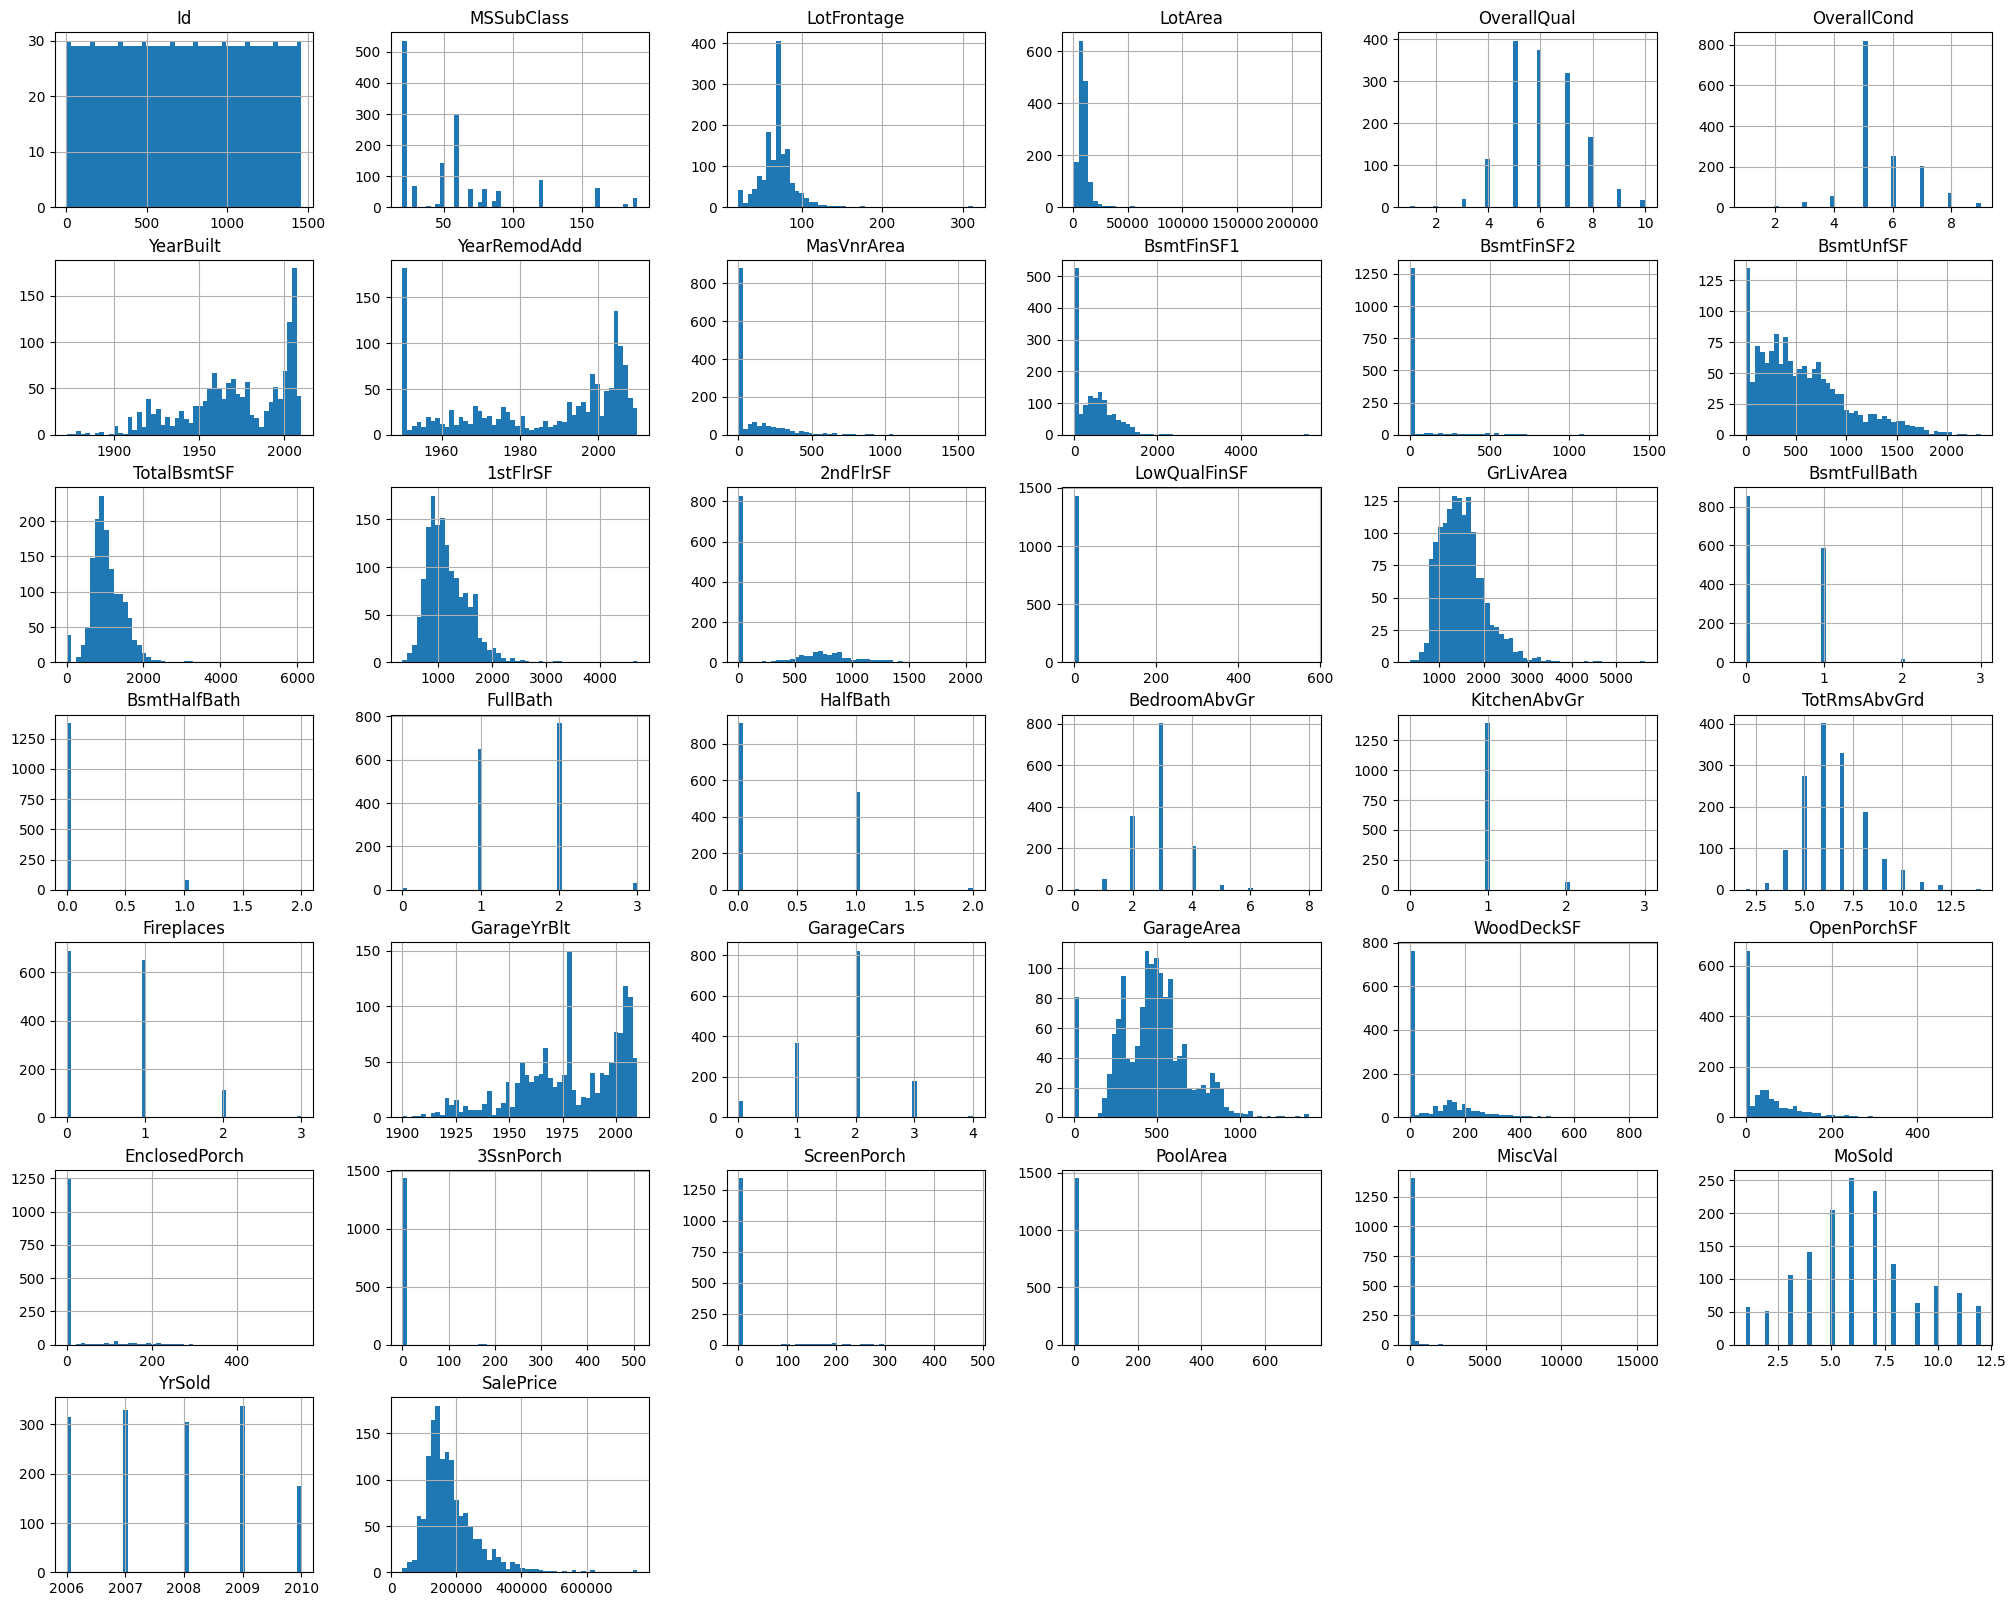

In [117]:
train_data.hist(bins=50, figsize=(25,20))
plt.show()

array([[<Axes: xlabel='SalePrice', ylabel='SalePrice'>,
        <Axes: xlabel='OverallQual', ylabel='SalePrice'>,
        <Axes: xlabel='GrLivArea', ylabel='SalePrice'>,
        <Axes: xlabel='GarageCars', ylabel='SalePrice'>,
        <Axes: xlabel='GarageArea', ylabel='SalePrice'>,
        <Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>,
        <Axes: xlabel='1stFlrSF', ylabel='SalePrice'>,
        <Axes: xlabel='FullBath', ylabel='SalePrice'>,
        <Axes: xlabel='YearBuilt', ylabel='SalePrice'>],
       [<Axes: xlabel='SalePrice', ylabel='OverallQual'>,
        <Axes: xlabel='OverallQual', ylabel='OverallQual'>,
        <Axes: xlabel='GrLivArea', ylabel='OverallQual'>,
        <Axes: xlabel='GarageCars', ylabel='OverallQual'>,
        <Axes: xlabel='GarageArea', ylabel='OverallQual'>,
        <Axes: xlabel='TotalBsmtSF', ylabel='OverallQual'>,
        <Axes: xlabel='1stFlrSF', ylabel='OverallQual'>,
        <Axes: xlabel='FullBath', ylabel='OverallQual'>,
        <Axes: xlabel='

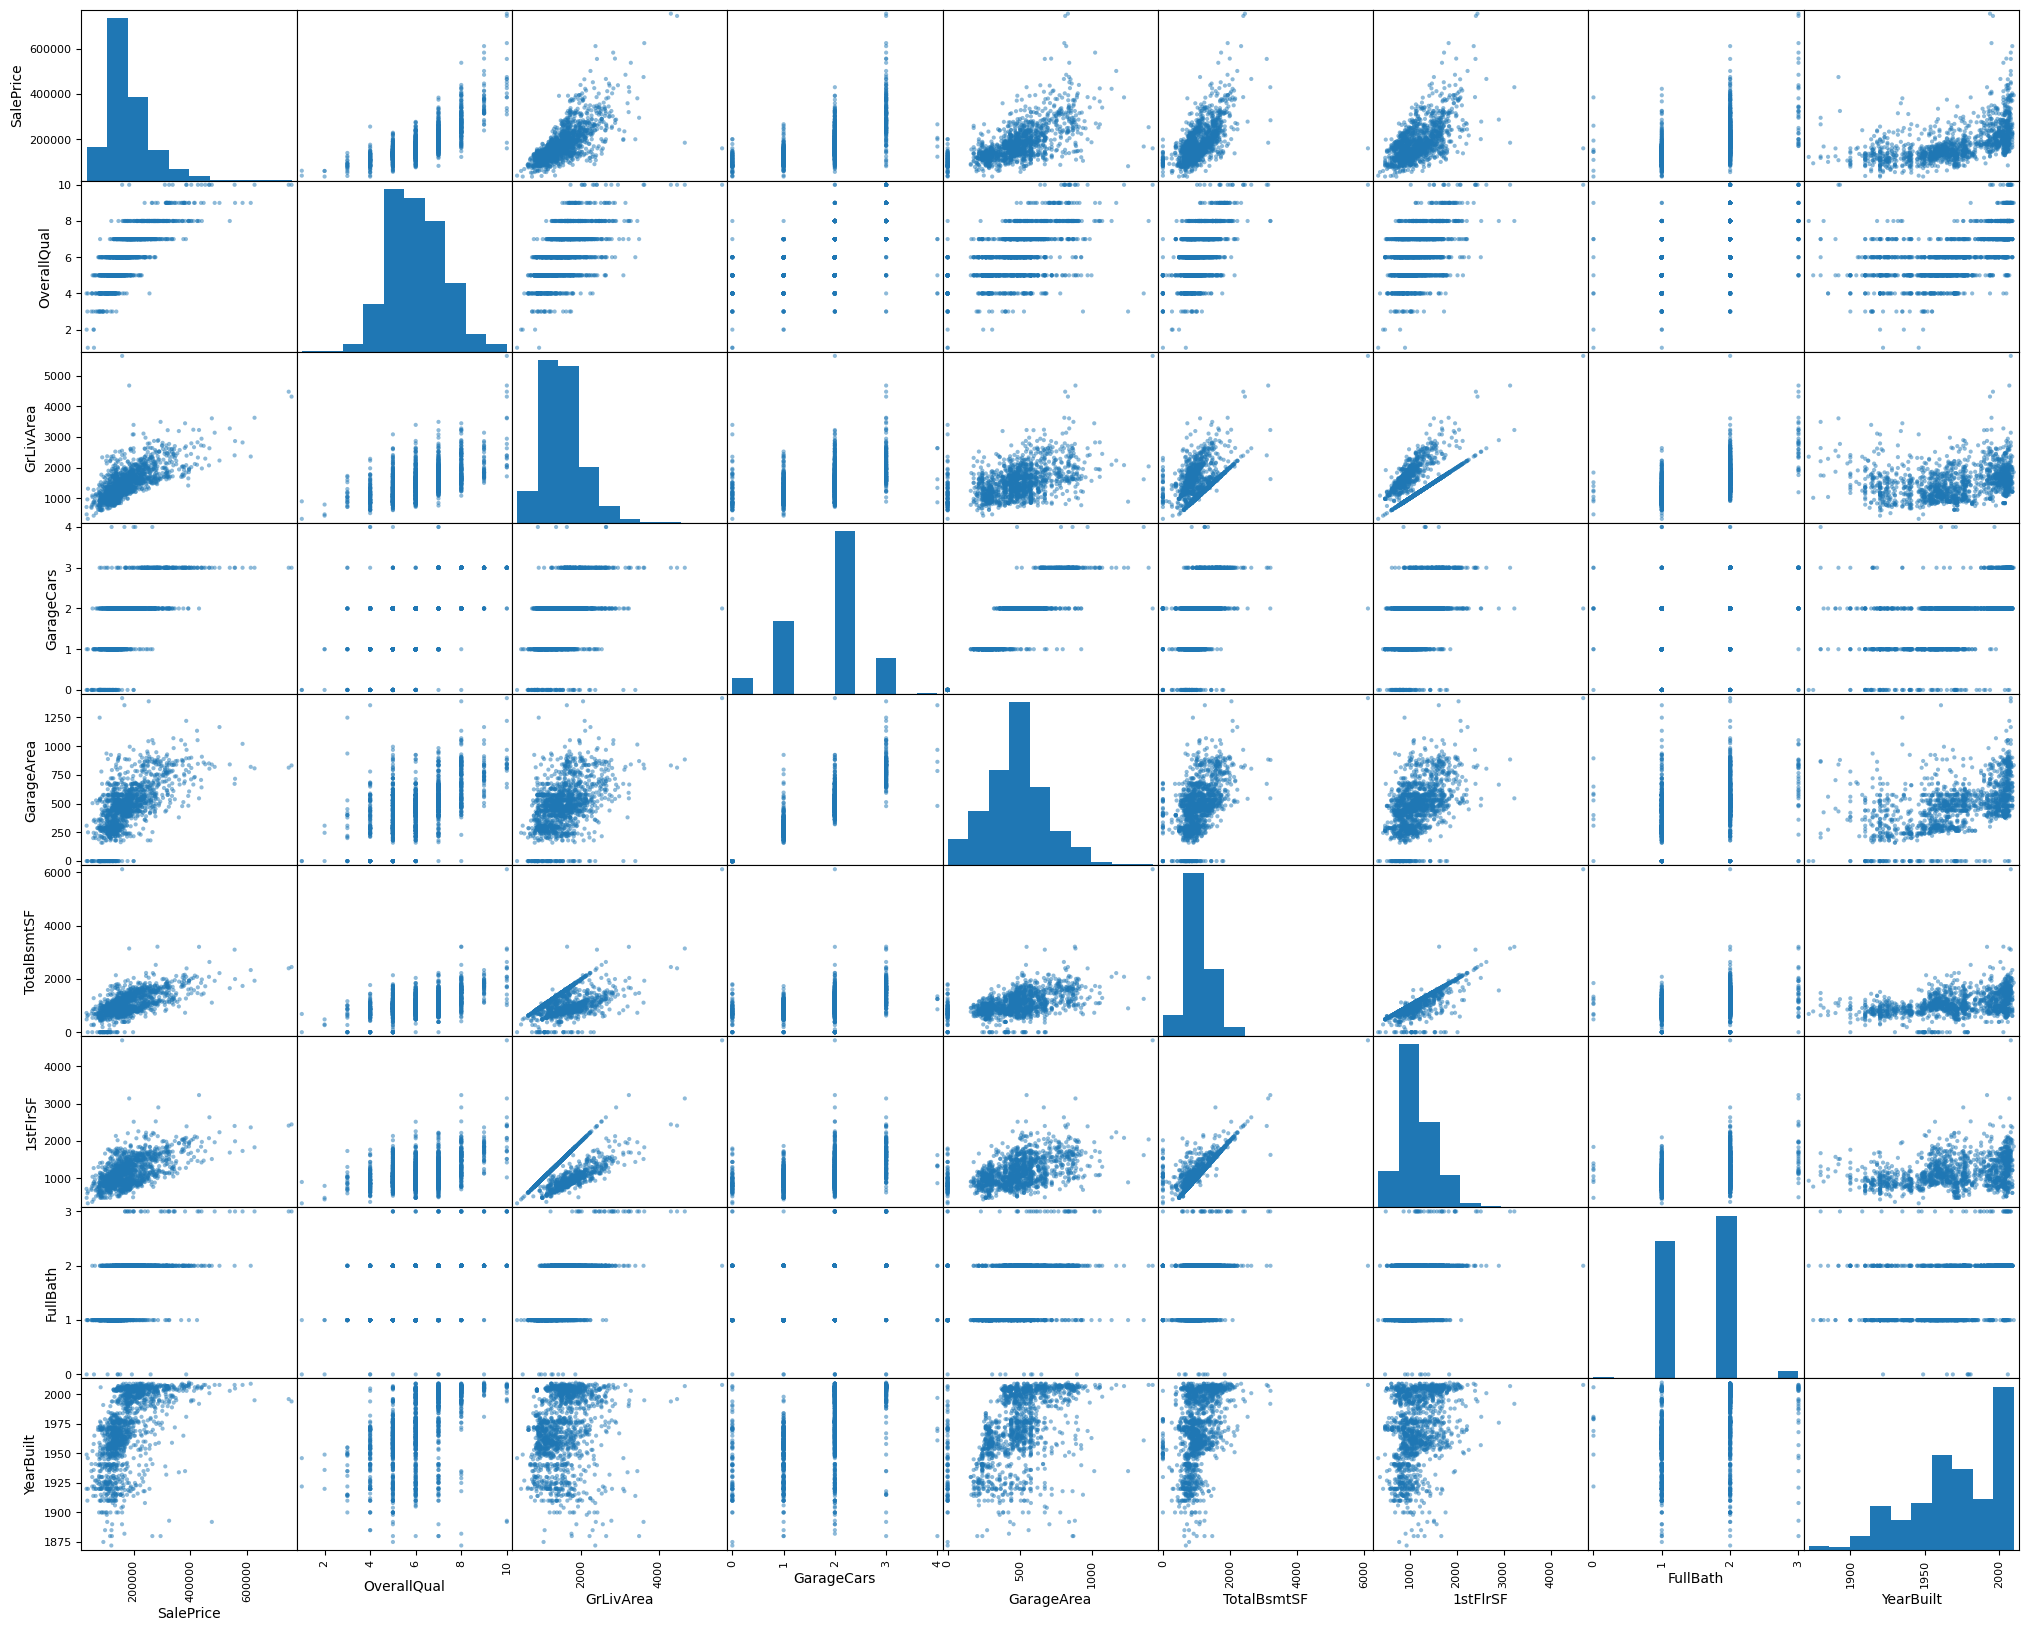

In [118]:
from pandas.plotting import scatter_matrix
attributes = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea","TotalBsmtSF","1stFlrSF", "FullBath","YearBuilt" ]
scatter_matrix(train_data[attributes], figsize=(25, 20))

### Correlation analysis

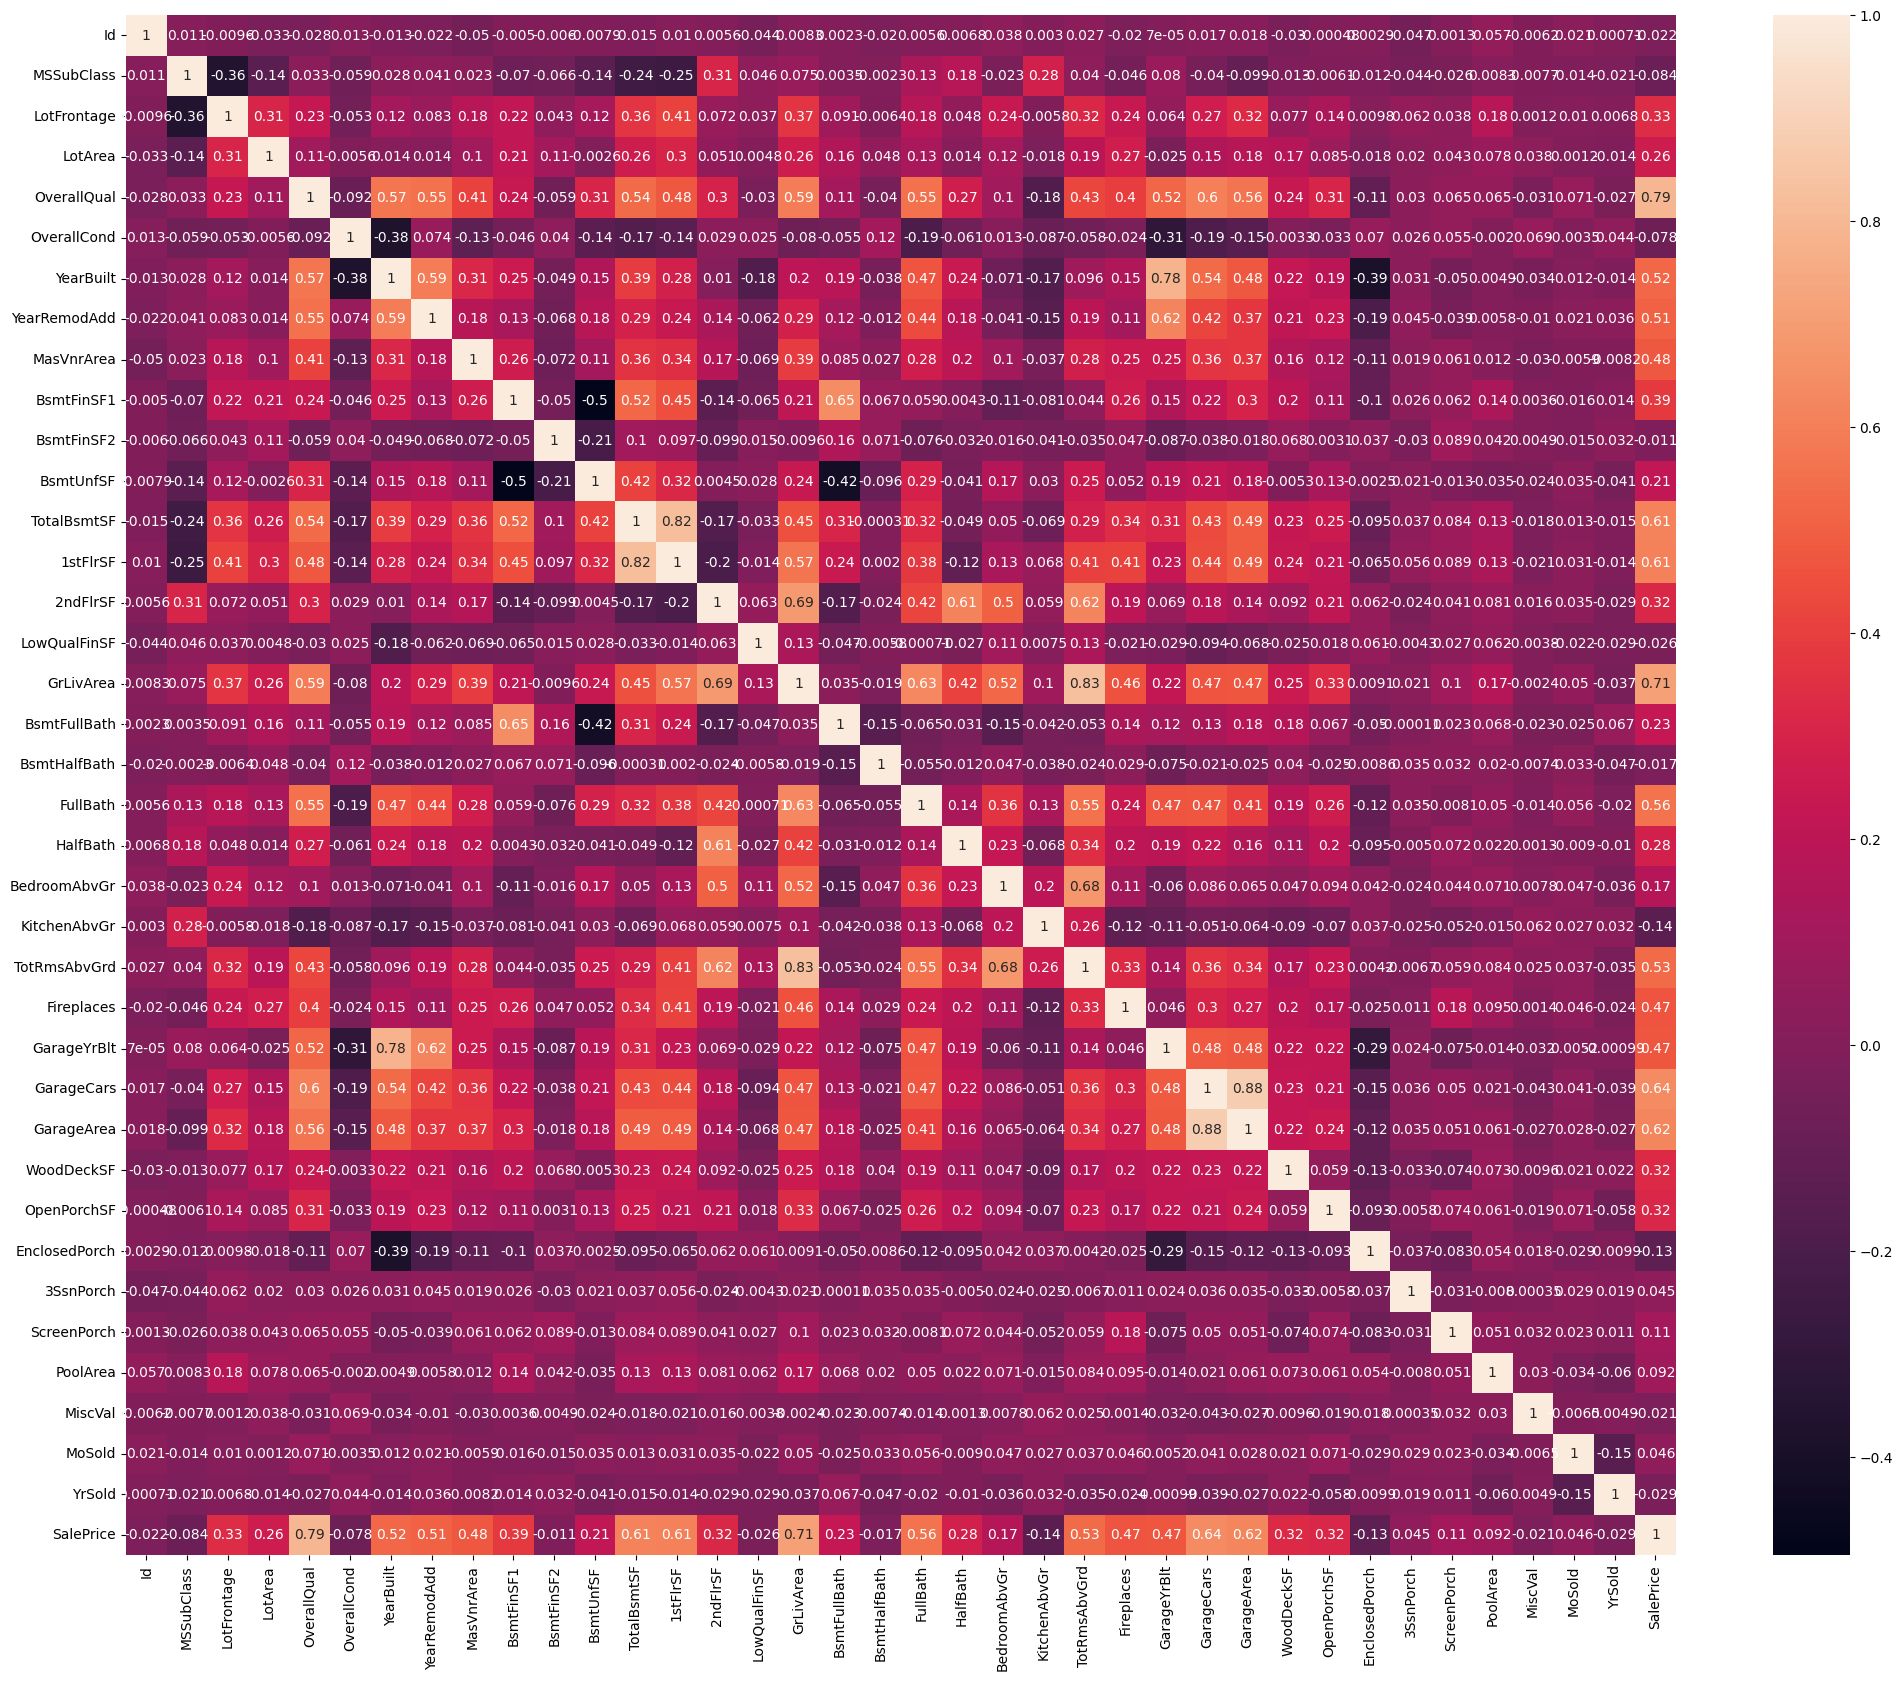

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation matrix
numerical_train_data = train_data.select_dtypes(include=[np.number])

# Now create the heatmap
plt.figure(figsize = (25,20))
sns.heatmap(numerical_train_data.corr(), annot=True)
plt.show()


In [120]:
import numpy as np
import pandas as pd

# Assuming train_data is your DataFrame
# Select only numerical columns for correlation matrix
numerical_train_data = train_data.select_dtypes(include=[np.number])

# Compute the correlation matrix
cor_matrix = numerical_train_data.corr().abs()

# Create the upper triangle matrix to identify correlated pairs
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

# Find the columns which have a correlation greater than 0.80
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]

# Print columns to be dropped
print("The attributes that need to be dropped are:\n", to_drop)


The attributes that need to be dropped are:
 ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


### Dropping the ID and the correlated attributes from the training and test set

In [121]:
train_data.drop(columns = to_drop, axis = 1, inplace = True)
test_data.drop(columns = to_drop, axis = 1, inplace = True)
# dropping id attributes
train_data.drop(labels = ['Id'], axis = 1, inplace = True)
test_data.drop(labels = ['Id'], axis = 1, inplace = True)

### Label encoding the data in both training and testing sets

In [122]:
from sklearn.preprocessing import LabelEncoder

for column in train_data.columns:
    encoder = LabelEncoder()
    encoder.fit(list(train_data[column].values))
    train_data[column] = encoder.transform(list(train_data[column].values))

In [123]:
for column in test_data.columns:
    encoder_test = LabelEncoder()
    encoder_test.fit(list(test_data[column].values))
    test_data[column] = encoder_test.transform(list(test_data[column].values))

### Data Partitioning

In [124]:
x_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]
x_test = test_data.iloc[:,:]

### Linear Regression

In [125]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
predictions_lr = lr.predict(x_test)

In [126]:
print("R-Square value: ", lr.score(x_train,y_train))

R-Square value:  0.9173997349951168


In [127]:
pd.DataFrame({'Predicted House Price Values': predictions_lr})

,Predicted House Price Values
0,70.417571
1,212.466596
2,304.282767
3,340.710713
4,286.327000
...,...
1454,-24.443803
1455,-58.408489
1456,249.736021
1457,78.533588


# **Question 4: Using Pre-trained LLMs**

(20 points)
Utilize a **pre-trained Large Language Model (LLM) from the Hugging Face Repository** for your specific task using the data collected in Assignment 3. After creating an account on Hugging Face (https://huggingface.co/), choose a relevant LLM from their repository, such as GPT-3, BERT, or RoBERTa or any Meta based text analysis model. Provide a brief description of the selected LLM, including its original sources, significant parameters, and any task-specific fine-tuning if applied.

Perform a detailed analysis of the LLM's performance on your task, including key metrics, strengths, and limitations. Additionally, discuss any challenges encountered during the implementation and potential strategies for improvement. This will enable a comprehensive understanding of the chosen LLM's applicability and effectiveness for the given task.

For this assignment, I have choosed the BERT




BERT is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google.

Description of BERT:

**Original Sources:** BERT was introduced in a 2018 paper by researchers at Google AI Language. It has since become a cornerstone in the field of NLP.

**Significant Parameters:** BERT is characterized by its deep bidirectional nature, meaning that it learns information from both the left and the right side of a token's context during the training phase.

**Task-Specific Fine-Tuning:** Although BERT is pre-trained on a large corpus, it can be fine-tuned with additional output layers to create state-of-the-art models for a wide range of tasks, such as question answering, sentiment analysis, etc.

###Step 1: Data Preparation


In [ ]:
!pip install accelerate -U
!pip install transformers

In [128]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Load the dataset
file_path = 'Assignment3.csv'
data = pd.read_csv(file_path)

In [129]:
data = data.dropna(subset=['clean_text', 'sentiment'])

In [130]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Map sentiment labels to numeric values
label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}
data['sentiment'] = data['sentiment'].map(label_mapping)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset
MAX_LEN = 128  # Maximum length of tokens
dataset = SentimentDataset(data['clean_text'].to_numpy(), data['sentiment'].to_numpy(), tokenizer, MAX_LEN)


###Step 2: Model Setup


In [131]:
# Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step 3: Fine-Tuning


In [132]:
# Fine-tuning the model
trainer.train()


Step,Training Loss
10,1.155000
20,1.081900
30,1.117800
40,1.068300
50,1.042000
60,1.038500
70,0.992700
80,0.890700
90,0.912800
100,0.897300


TrainOutput(global_step=429, training_loss=0.6300569814401906, metrics={'train_runtime': 6102.161, 'train_samples_per_second': 1.118, 'train_steps_per_second': 0.07, 'total_flos': 448739933935104.0, 'train_loss': 0.6300569814401906, 'epoch': 3.0})

**Conclusion:**

**Key Metrics:** The performance of BERT is evaluated using metrics like accuracy, precision, recall, and F1 score, which are essential for understanding its effectiveness like sentiment analysis.


**Strengths:** BERT excels in contextual understanding due to its bidirectional nature, benefits from transfer learning through its pre-trained background, and offers flexibility for various NLP.


**Limitations:** The model demands high computational resources, poses a risk of overfitting, especially with small datasets, and struggles with processing long texts due to token limits.


**Challenges:** Implementational challenges include the need for thorough data preparation, tuning the model to avoid overfitting, and the complexity of interpreting the model's decisions.


**Improvement Strategies: ** Enhancing BERT's performance can involve data augmentation, regularization to prevent overfitting, hyperparameter tuning, using simplified models like DistilBERT for resource constraints, and adapting the model for longer texts.
